<a href="https://colab.research.google.com/github/ahmedlabib02/Nlp-project/blob/main/Nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone 1

In [ ]:
%pip install transformers
%pip install nltk
%pip install farasapy
%pip install --quiet camel-tools-data
%pip install camel-tools
%pip install camel-tools -f https://download.pytorch.org/whl/torch_stable.html

%pip install arabic-reshaper
%pip install python-bidi
%pip install wordcloud
%pip install WordCloud
%pip install --upgrade -f https://download.pytorch.org/whl/torch_stable.html camel-tools

In [5]:
import os 
import zipfile
import json
import re
import pandas as pd
from collections import Counter
import string
from wordcloud import WordCloud
from transformers import BertTokenizer
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from farasa.segmenter import FarasaSegmenter
from nltk.stem.isri import ISRIStemmer
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
segmenter = FarasaSegmenter(interactive=False)
nltk.download('stopwords')




c:\Users\sana2\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sana2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data preparation

#### Unzipping the "B Hodoo2" channel folder

In [96]:
def unzip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [97]:
# unzip("B_hodoo2.zip.zip", "./")
# unzip( "kefaya_ba2a.zip", "./")
unzip("al_mokhbir_al_eqtisadi.zip",'./')


**Al mokhbir channel has different metadata structure so modify the structure to make similar to others**

In [6]:
channel_folder = './al_mokhbir_al_eqtisadi'
metadata_folder = os.path.join(channel_folder, 'metadata')
annotations = []


for filename in os.listdir(metadata_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(metadata_folder, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                data["category"] = data["categories"][0]
                annotations.append(data)
            except Exception as e:
                print(f"Error processing {filename}: {e}")



output_file = os.path.join(channel_folder, 'annotations.json')
with open(output_file, 'w', encoding='utf-8') as f_out:
    json.dump(annotations, f_out, ensure_ascii=False, indent=4)




In [7]:
os.rename('al_mokhbir_al_eqtisadi/raw_data','al_mokhbir_al_eqtisadi/raw')

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'al_mokhbir_al_eqtisadi/raw_data' -> 'al_mokhbir_al_eqtisadi/raw'

### Building dict for annotations and text

**there is a slight inconsistency in the naming of the annotation and the corresponding txt file**

In [8]:
def standardize(title):
    title = title.replace("_", " ").lower()
    title = re.sub(r'ـ+', '', title)
    title = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', title)
    title = re.sub(r'[^\w\s]', '', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

In [9]:
def get_category_for_filename(target_filename, annotations_path):
    with open(annotations_path, 'r', encoding='utf-8') as f_json:
        annotations = json.load(f_json)
    
    base_target = os.path.splitext(target_filename)[0]
    target_can = standardize(base_target)
    print("Target standardized:", target_can)  
    for entry in annotations:
        annotation_title = entry.get('title')
        if annotation_title:
            annotation_can = standardize(annotation_title)
            print("Annotation standardized:", annotation_can) 
            if annotation_can == target_can:
                return entry.get('category')
    return None

In [27]:
def add_transcripts_from_folder(transcripts_dict, folder_path, channel, max_transcripts=None):
    annotations_json = os.path.join(folder_path, 'annotations.json')
    raw_folder = os.path.join(folder_path, 'raw')
    count = 0
    for filename in os.listdir(raw_folder):
        if max_transcripts is not None and count >= max_transcripts:
            break
        full_path = os.path.join(raw_folder, filename)
        if os.path.isfile(full_path):
            with open(full_path, 'r', encoding='utf-8') as file:
                transcript = file.read()
            category = get_category_for_filename(filename, annotations_json)
            base_filename, _ = os.path.splitext(filename)
            transcripts_dict[base_filename] = (channel, category, transcript)
            count += 1
    return transcripts_dict

In [28]:
transcripts_dict = {}
first_folder_path = './B Hodoo2/'
second_folder_path = './Kefaya Ba2a/'
third_folder_path = './al_mokhbir_al_eqtisadi'
transcripts_dict = add_transcripts_from_folder(transcripts_dict, first_folder_path,  'B Hodoo2')
transcripts_dict = add_transcripts_from_folder(transcripts_dict, second_folder_path, 'Kefaya Ba2a')
transcripts_dict = add_transcripts_from_folder(transcripts_dict, third_folder_path, 'al mokhbir al eqtisadi',max_transcripts=25)

Target standardized: أكبر كذبة في التاريخ وهم الانتاجية بودكاست بهدوء مع كريم جلسة 19
Annotation standardized: إزاي ضاعفت دخلي بدون شغل إضافي عن الرزق ووسعه بودكاست بهدوء مع كريم جلسة 21
Annotation standardized: لماذا نيأس عن فلسفة المثابرة بودكاست بهدوء مع كريم جلسة 20
Annotation standardized: أكبر كذبة في التاريخ وهم الانتاجية بودكاست بهدوء مع كريم جلسة 19
Target standardized: إزاي ضاعفت دخلي بدون شغل إضافي عن الرزق ووسعه بودكاست بهدوء مع كريم جلسة 21
Annotation standardized: إزاي ضاعفت دخلي بدون شغل إضافي عن الرزق ووسعه بودكاست بهدوء مع كريم جلسة 21
Target standardized: اخطر محتوى في العالم بودكاست بهدوء مع كريم جلسة 13
Annotation standardized: إزاي ضاعفت دخلي بدون شغل إضافي عن الرزق ووسعه بودكاست بهدوء مع كريم جلسة 21
Annotation standardized: لماذا نيأس عن فلسفة المثابرة بودكاست بهدوء مع كريم جلسة 20
Annotation standardized: أكبر كذبة في التاريخ وهم الانتاجية بودكاست بهدوء مع كريم جلسة 19
Annotation standardized: تخلص من الكلام السلبي والتنمر بودكاست بهدوء مع كريم جلسة 17
Annotatio

In [29]:
transcripts_dict

{'أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودكاست بهدوء مع كريم _ جلسة 19': ('B Hodoo2',
  'Education',
  'النهارده الفيديو بتاعنا على\nالانتاجيه لان النهارده الفيديو رقم 500 ل\nهي على قناه اليوتيوب وبحسبه صغيره صديقي\nالمشاهد فيديو كل اسبوع يعني اربع\nفيديوهات في الشهر اربع فيديوهات في الشهر\nيعني 12 يعني 48 فيديو في السنه ولو\nضربناهم في الثمان سنين هيبقوا اقل من 500\nفاذا انا شخصيا بقي اكت من ممان سنين\nمنتجه على اليوتيوب فيحق ل ان انا اكلمك\nعن الانتاجيه بس الحقيقه ان ما يحق ليش\nخالص اكلمك على الانتاجيه لو ضربت المثل\nده لان المثل ده هو الارقام اللي اتقالت\nفيه كلها صحيحه بدون اي كذب بس الحقيقه لو\nانت متابع جيد واعمل سبسكرايب ومفعل الجرس\nهتعرف ان كريم اسماعيل مش شخصيه ملتزمه في\nاليوتيوب وما بينزلش فيديو كل اسبوع لمده\nممان سنين واللي عمل السبايك بتاعه\nالارقام ديت ان انا جت عل فتره كنت بنزل\nفيديو كل يوم لكن غير كده انا عمري ما\nاستمريت اكتر من لاث شهور على اليوتيوب\nبنزل فيديو كل اسبوع لان اليوتيوب اصلا مش\nمهنتي الاساسيه ومش شغلتي الاساسيه و\nبالتالي انا مش محتاج اصلا التزم

### Creating a dataframe

In [30]:
data = [(title, info[0], info[1], info[2]) for title, info in transcripts_dict.items()]
df = pd.DataFrame(data, columns=['title', 'channel', 'category', 'transcript'])
print(df.head())


                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...  
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...  
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...  
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...  
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...  


### Before pre-processing analysis

**Reveals the number of rows and columns, data types of each column, and non-null counts.**

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       73 non-null     object
 1   channel     73 non-null     object
 2   category    72 non-null     object
 3   transcript  73 non-null     object
dtypes: object(4)
memory usage: 2.4+ KB


**Identifying which columns have missing values**

In [32]:
print(df.isnull().sum())

title         0
channel       0
category      1
transcript    0
dtype: int64


**Since there are some entries without categories or an annotation file, we just remove them.**

In [33]:
df = df[df['category'].notna()]

**Measuring number of transcript and exploring outliers**

In [34]:
df['raw_length'] = df['transcript'].apply(len)
print(df['raw_length'].describe())

count       72.000000
mean     18706.652778
std       9296.437232
min        370.000000
25%      12356.750000
50%      17220.000000
75%      22676.250000
max      51920.000000
Name: raw_length, dtype: float64


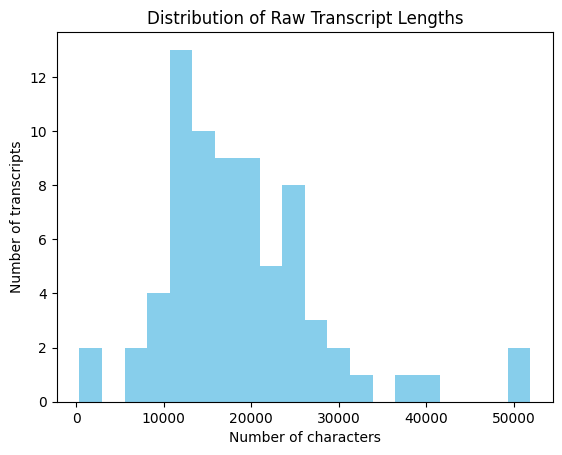

In [35]:
import matplotlib.pyplot as plt

plt.hist(df['raw_length'], bins=20, color='skyblue')
plt.xlabel("Number of characters")
plt.ylabel("Number of transcripts")
plt.title("Distribution of Raw Transcript Lengths")
plt.show()

category
Education         26
Entertainment     25
People & Blogs    17
Comedy             4
Name: count, dtype: int64


<Axes: title={'center': 'Category Distribution'}, xlabel='category'>

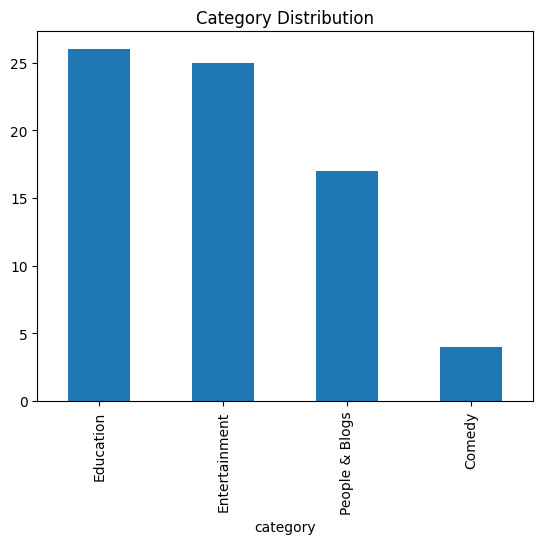

In [36]:
print(df['category'].value_counts())
df['category'].value_counts().plot(kind='bar', title='Category Distribution')

In [37]:
print(df['channel'].unique())
print(df['channel'].value_counts())

['B Hodoo2' 'Kefaya Ba2a' 'al mokhbir al eqtisadi']
channel
B Hodoo2                  26
al mokhbir al eqtisadi    25
Kefaya Ba2a               21
Name: count, dtype: int64


**Viewing most common words before preprocessing**

In [38]:
all_text = " ".join(df['transcript'])
words = all_text.split()
word_freq = Counter(words)
print("Top 10 most common words in raw transcripts:")
print(word_freq.most_common(10))

Top 10 most common words in raw transcripts:
[('في', 8259), ('اللي', 4362), ('من', 4198), ('ما', 3996), ('انا', 3849), ('ده', 3335), ('على', 3139), ('هو', 2928), ('ان', 2918), ('انت', 2864)]


**Viewing the most common words per category**

In [39]:
def top_words_for_category(cat, n=10):
    subset = df[df['category'] == cat]
    combined_text = " ".join(subset['transcript'])
    words = combined_text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)
categories = df['category'].unique()
for cat in categories:
    print(f"Category: {cat}")
    top_words = top_words_for_category(cat, n=5)
    for word, count in top_words:
        print(f"  {word}: {count}")

Category: Education
  في: 3018
  انا: 2115
  اللي: 1838
  ان: 1789
  من: 1780
Category: People & Blogs
  في: 2135
  انت: 1332
  انا: 1327
  ما: 1285
  هو: 1259
Category: Comedy
  في: 573
  ما: 399
  يا: 391
  انا: 381
  انت: 364
Category: Entertainment
  في: 2533
  من: 1461
  اللي: 1109
  على: 906
  ما: 666


### Cleaning the data

#### Removing numbers, non-Arabic letters and extra spaces

In [40]:
def clean_text(text):
    punctuations = string.punctuation + "؟،؛«»…ـ"  
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)  
    text = re.sub(r'[0-9A-Za-z]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [41]:
df["clean_transcript"] = df["transcript"].apply(clean_text)
print(df.head())

                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  raw_length  \
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...       21032   
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...       18261   
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...       18546   
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...       23874   
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...       11462   

                                    clean_transcript  
0  النهارده الفيديو بتاعنا على الانتاجيه لان النه...  
1  انا النهارده جا

### Tokenization 

In [42]:
def bert_tokenize(df):
    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
    df['bert_tokens'] = df['clean_transcript'].apply(lambda x: tokenizer.tokenize(str(x)))
bert_tokenize(df)
print(df["bert_tokens"].head())

0    [ال, ##نها, ##رد, ##ه, ال, ##فيد, ##يو, ب, ##ت...
1    [ان, ##ا, ال, ##نها, ##رد, ##ه, جا, ##ي, ا, ##...
2    [ال, ##نها, ##رد, ##ه, ان, ##ا, جا, ##ي, ا, ##...
3    [ب, ##صر, ##اح, ##ه, ان, ##ا, موضوع, ان, ا, ##...
4    [م, ##ساء, ال, ##فل, ال, ##فيد, ##يو, ده, عن, ...
Name: bert_tokens, dtype: object


**We will use more dialect specific tokenizers using libraries like Farasa**

In [43]:
def farasa_tokenize(text):
    text = str(text)
    segmented_text = segmenter.segment(text)
    tokens = segmented_text.split()
    return tokens

df['farasa_tokens'] = df['transcript'].apply(farasa_tokenize)
df['farasa_tokens'] 

0     [النهارده, ال+فيديو, بتاع+نا, على, ال+انتاجيه,...
1     [أنا, النهارده, جاي, اقوللك, ازاي, تزود, من, د...
2     [النهارده, أنا, جاي, اتكلم, على, واحد+ه, من, أ...
3     [ب+صراح+ه, أنا, موضوع, ان, اح+نا, مش, عارف+ين,...
4     [مساء, ال+فل, ال+فيديو, ده, عن, ال+رزق, لو, أن...
                            ...                        
68    [قبل, ثلاث, أيام, ب+ال+ظبط, من, غزو, روسيا, ل+...
69    [عارف+ين, هولندا, ؟, أكيد, عارفين+ها, و+أكيد, ...
70    [في, يناير, 2024, محافظ, ال+بنك, ال+مركزي, ال+...
71    [يوم, 8, مارس, 2023, بنك, Silvergate, ال+أمريك...
72    [اللي, ب+يملك, ال+بطاري+ات, هو, اللي, ب+يملك, ...
Name: farasa_tokens, Length: 72, dtype: object

**Plus signs generated with farasa tokenizition may introduce noise so we remove them**

In [44]:
def remove_plus_signs(tokens):
    return [token.replace('+', '') for token in tokens]

df['farasa_tokens'] = df['farasa_tokens'].apply(remove_plus_signs)
df['farasa_tokens']

0     [النهارده, الفيديو, بتاعنا, على, الانتاجيه, لا...
1     [أنا, النهارده, جاي, اقوللك, ازاي, تزود, من, د...
2     [النهارده, أنا, جاي, اتكلم, على, واحده, من, أخ...
3     [بصراحه, أنا, موضوع, ان, احنا, مش, عارفين, نتب...
4     [مساء, الفل, الفيديو, ده, عن, الرزق, لو, أنت, ...
                            ...                        
68    [قبل, ثلاث, أيام, بالظبط, من, غزو, روسيا, لاوك...
69    [عارفين, هولندا, ؟, أكيد, عارفينها, وأكيد, برض...
70    [في, يناير, 2024, محافظ, البنك, المركزي, الإيط...
71    [يوم, 8, مارس, 2023, بنك, Silvergate, الأمريكي...
72    [اللي, بيملك, البطاريات, هو, اللي, بيملك, المس...
Name: farasa_tokens, Length: 72, dtype: object

### Stop word removal

**Analysing the stop word removal in each in transcript**

In [45]:
arabic_stopwords = set(stopwords.words('arabic'))

In [46]:
def count_stopwords(tokens, stopwords_set):
    return sum(1 for token in tokens if token in stopwords_set)

In [47]:
# df['stopword_count'] = df['farasa_tokens'].apply(lambda tokens: count_stopwords(tokens, arabic_stopwords))
df['total_tokens'] = df['farasa_tokens'].apply(len)

# print(df[['stopword_count', 'total_tokens']].head())

**Removing the stop words**

In [48]:
def remove_stopwords(tokens, stopwords_set):
    return [token for token in tokens if token not in stopwords_set]

In [49]:
df['tokens_no_stop'] = df['farasa_tokens'].apply(lambda tokens: remove_stopwords(tokens, arabic_stopwords))
df['total_tokens_no_stop'] = df['tokens_no_stop'].apply(len)
print(df[['total_tokens', 'total_tokens_no_stop']].head())

   total_tokens  total_tokens_no_stop
0          4192                  3242
1          3652                  2883
2          3532                  2756
3          4657                  3607
4          2308                  1756


### Removing custom egyptian stop words


In [50]:
vectorizer = TfidfVectorizer(use_idf=True)
tfidf_matrix = vectorizer.fit_transform(df['clean_transcript'])
idf = vectorizer.idf_
terms = vectorizer.get_feature_names_out()
term_idf = list(zip(terms, idf))
common_words = [term for term, score in term_idf if score < np.percentile(idf, 5)]
print("Candidate stopwords based on low IDF:", common_words)


Candidate stopwords based on low IDF: ['أشرف', 'أصلا', 'أكتر', 'أنا', 'أو', 'أول', 'أي', 'إبراهيم', 'إحنا', 'إزاي', 'إن', 'إنه', 'إنها', 'إنهم', 'إيه', 'اب', 'ابتدت', 'ابتدى', 'ابتدي', 'ابتديت', 'ابدا', 'ابراهيم', 'ابسط', 'ابص', 'ابقى', 'ابن', 'ابني', 'ابو', 'ابويا', 'ابيض', 'اتس', 'اتفرج', 'اتكلم', 'اتكلمت', 'اتكلمنا', 'اتمنى', 'اتنين', 'اثر', 'اثنين', 'اجتماع', 'اجري', 'اجي', 'اجيب', 'احد', 'احساس', 'احسن', 'احمد', 'احنا', 'احيانا', 'اختبار', 'اخد', 'اخر', 'اخرج', 'اخرى', 'اخش', 'اخويا', 'اخي', 'ادي', 'اذا', 'ارباع', 'اربع', 'اربعه', 'ارجع', 'ارض', 'اروح', 'از', 'ازاي', 'اس', 'اسئله', 'اساس', 'اساسي', 'اسال', 'استماعكم', 'اسف', 'اسكندريه', 'اسم', 'اسماعيل', 'اسمع', 'اسمه', 'اسمها', 'اشترك', 'اشتركوا', 'اشتغل', 'اشرف', 'اشوف', 'اصحاب', 'اصحابي', 'اصل', 'اصلا', 'اطار', 'اطلع', 'اطول', 'اعتقد', 'اعرف', 'اعرفش', 'اعلم', 'اعلى', 'اعمال', 'اعمل', 'اف', 'افتح', 'افتكر', 'افضل', 'افكار', 'افنت', 'افهم', 'اقدر', 'اقرب', 'اقسم', 'اقعد', 'اقل', 'اقول', 'اقوله', 'اقولها', 'اكبر', 'اكت', 'اكتب', 

In [51]:
egyptian_stopwords = {"انت","يا","قبل","في","علي","عن","الي","من","بلاش",  "ايه",  "يعني",  "أوي",  "اللي","انا","ده" , "مش","دي","بقى", "كده","مالوش","بس","ال", "ان", "عل", "كد", "نا", "بتاع"
}
common_words = common_words + list(egyptian_stopwords)
df['tokens_no_stop_additional'] = df['tokens_no_stop'].apply(lambda tokens: remove_stopwords(tokens, set(common_words)))
df['total_tokens_no_stop_custom'] = df['tokens_no_stop_additional'].apply(len)
df[['total_tokens','total_tokens_no_stop', 'total_tokens_no_stop_custom']].head()

,total_tokens,total_tokens_no_stop,total_tokens_no_stop_custom
0,4192,3242,1234
1,3652,2883,1231
2,3532,2756,1127
3,4657,3607,1472
4,2308,1756,678


### Stemming and Lemmatization

**Stemming**

In [52]:
stemmer = ISRIStemmer()
df['stemmed_tokens'] = df['tokens_no_stop_additional'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
df['stemmed_tokens'][0]

['ناج',
 '500',
 'قنه',
 'حسب',
 'شهد',
 'سبع',
 '12',
 '48',
 'ضرب',
 'ثمن',
 'هيبق',
 '500',
 'مان',
 'نجه',
 'يحق',
 'كلم',
 'ناج',
 'يحق',
 'ليش',
 'كلم',
 'ناج',
 'ضرب',
 'مثل',
 'مثل',
 'رقم',
 'تقل',
 'صحح',
 'كذب',
 'تبع',
 'جيد',
 'سبسكرايب',
 'فعل',
 'جرس',
 'اعل',
 'لزم',
 'زلش',
 'سبع',
 'مان',
 'سبي',
 'رقم',
 'نزل',
 'مري',
 'نزل',
 'سبع',
 'هنت',
 'شغل',
 'تلي',
 'تزم',
 'يدو',
 'سبع',
 'بقم',
 'جيت',
 'جهد',
 'هبد',
 'اقل',
 'ناج',
 'اعل',
 'جنب',
 'دخل',
 'كلش',
 'اصل',
 'ناج',
 'تعل',
 'علم',
 'وأن',
 'قولل',
 'بعل',
 'حطل',
 'رقم',
 'خدع',
 'لنس',
 '5',
 '',
 '7',
 'تسو',
 '12',
 'ضرب',
 '12',
 '3',
 '24',
 'ترح',
 'ديل',
 'ماف',
 'حسب',
 'صحح',
 'وحج',
 '1',
 '1',
 'سسو',
 'ماكدبتش',
 'خبط',
 'رقم',
 'قنع',
 'مخك',
 'سمع',
 'خلف',
 'ناج',
 'وصل',
 '500',
 'ناج',
 'يرج',
 'عقل',
 'خرج',
 'يجب',
 'ثمن',
 'فتر',
 'نزل',
 'فتر',
 'زلش',
 'شهر',
 'خفي',
 'شهر',
 'عمل',
 'يوتيوبرز',
 'هنلعب',
 'ختف',
 'وعد',
 'ككريم',
 'اعل',
 'للل',
 'تثر',
 'سلب',
 'جيت',
 'هنه',
 'جنب'

In [53]:
db = MorphologyDB.builtin_db('calima-msa-r13', flags='a')
analyzer = Analyzer(db)

def get_lemma(word):
    analyses = analyzer.analyze(word)
    if analyses:
        return analyses[0].get('lemma', word)
    return word
def lemmatize_tokens(tokens):
    """
    Given a list of tokens (from your 'tokens_no_stop' column),
    apply lemmatization to each token and return the list of lemmas.
    """
    return [get_lemma(token) for token in tokens]

df['lemmatized_tokens'] = df['tokens_no_stop_additional'].apply(lemmatize_tokens)
# print(df[['title', 'lemmatized_tokens']].head())

In [54]:
print("Original tokens (from tokens_no_stop_additional):")
print(df.loc[0, 'tokens_no_stop_additional'])

print("\nStemmed tokens:")
print(df.loc[0, 'stemmed_tokens'])


print("\nLemmatized tokens:")
print(df.loc[0, 'lemmatized_tokens'])

Original tokens (from tokens_no_stop_additional):
['الانتاجيه', '500', 'قناه', 'وبحسبه', 'المشاهد', 'أسبوع', '12', '48', 'ضربناهم', 'الثمان', 'هيبقوا', '500', 'ممان', 'منتجه', 'فيحق', 'اكلمك', 'الانتاجيه', 'يحق', 'ليش', 'اكلمك', 'الانتاجيه', 'ضربت', 'المثل', 'المثل', 'الأرقام', 'اتقالت', 'صحيحه', 'كذب', 'متابع', 'جيد', 'سبسكرايب', 'ومفعل', 'الجرس', 'إسماعيل', 'ملتزمه', 'بينزلش', 'أسبوع', 'ممان', 'السبايك', 'الأرقام', 'بنزل', 'استمريت', 'بنزل', 'أسبوع', 'مهنتي', 'شغلتي', 'بالتالي', 'التزم', 'بفيديو', 'أسبوع', 'بقيم', 'انجيتي', 'مجهودي', 'بتهبد', 'أقول', 'انتاجيه', 'إسماعيل', 'نتجنب', 'الدخله', 'الكليشيه', 'أصل', 'الإنتاجات', 'فتعال', 'اعلمك', 'وأنا', 'اقوللك', 'بعلك', 'احطلك', 'أرقام', 'الخدع', 'لناس', '5', '', '7', 'بتساوي', '12', 'اضرب', '12', '3', '24', 'وتروح', 'مديله', 'الماف', 'الحساب', 'وصحيح', 'وحاجه', '1', '1', 'سساوي', 'ماكدبتش', 'يلخبط', 'الأرقام', 'بتقتنع', 'مخك', 'اسمعه', 'الخلفيه', 'الانتاجيه', 'نوصل', '500', 'الانتاجيه', 'يروج', 'عقولنا', 'بمخرجات', 'ايجابيه', 'الثمان', '

*results from lemmatization are not adequate*

### More Analysis

**Vocabulary Size after Preprocessing**

In [55]:
all_stemmed_tokens = [token for tokens in df['stemmed_tokens'] for token in tokens]
vocab = set(all_stemmed_tokens)
token_freq = Counter(all_stemmed_tokens)
print("Vocabulary size:", len(vocab))
print("Top 10 most frequent lemmas:", token_freq.most_common(10))

Vocabulary size: 10109
Top 10 most frequent lemmas: [('عمل', 899), ('امر', 799), ('وأن', 563), ('انس', 454), ('علم', 382), ('عرف', 357), ('اخر', 346), ('سلم', 345), ('جمع', 322), ('فكر', 315)]


In [56]:
all_lemmatized_tokens = [token for tokens in df['lemmatized_tokens'] for token in tokens]
vocab = set(all_lemmatized_tokens)
token_freq = Counter(all_lemmatized_tokens)
print("Vocabulary size:", len(vocab))
print("Top 10 most frequent lemmas:", token_freq.most_common(10))

Vocabulary size: 35014
Top 10 most frequent lemmas: [('الإنسان', 338), ('وأنا', 310), ('وأنت', 232), ('؟', 206), ('فأنا', 187), ('الآخر', 176), ('لالله', 171), ('أقول', 162), ('أكبر', 158), ('أعمل', 150)]


**Document length distribution**

In [59]:
df.columns

Index(['title', 'channel', 'category', 'transcript', 'raw_length',
       'clean_transcript', 'bert_tokens', 'farasa_tokens', 'total_tokens',
       'tokens_no_stop', 'total_tokens_no_stop', 'tokens_no_stop_additional',
       'total_tokens_no_stop_custom', 'stemmed_tokens', 'lemmatized_tokens'],
      dtype='object')

Stemmed Tokens Length Stats:
count      72.000000
mean     1277.347222
std       564.273637
min        42.000000
25%      1015.750000
50%      1231.500000
75%      1519.500000
max      3377.000000
Name: stem_length, dtype: float64

Lemmatized Tokens Length Stats:
count      72.000000
mean     1277.347222
std       564.273637
min        42.000000
25%      1015.750000
50%      1231.500000
75%      1519.500000
max      3377.000000
Name: lemma_length, dtype: float64


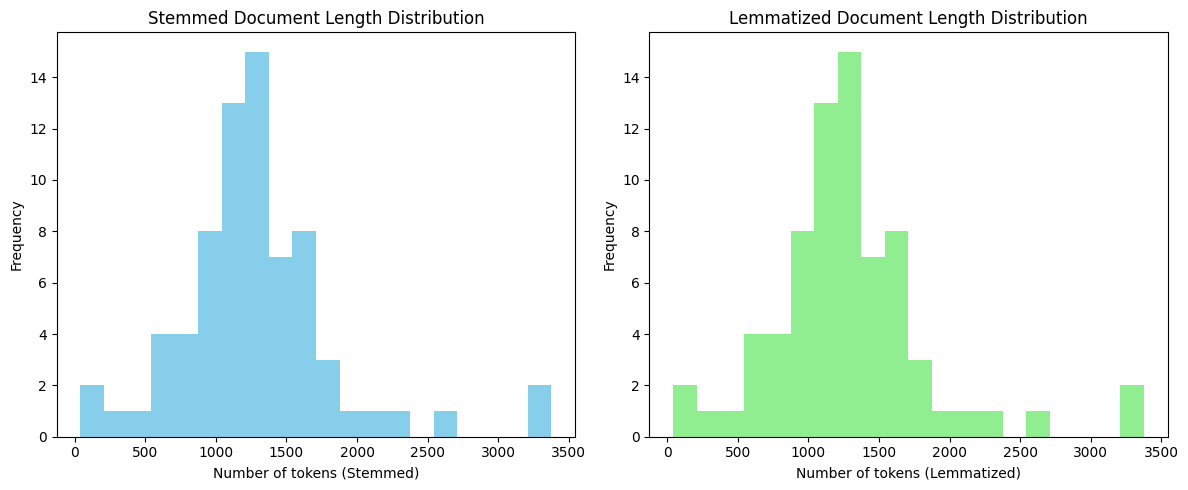

In [60]:
df['stem_length'] = df['stemmed_tokens'].apply(len)
df['lemma_length'] = df['lemmatized_tokens'].apply(len)


print("Stemmed Tokens Length Stats:")
print(df['stem_length'].describe())
print("\nLemmatized Tokens Length Stats:")
print(df['lemma_length'].describe())


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['stem_length'], bins=20, color='skyblue')
plt.xlabel("Number of tokens (Stemmed)")
plt.ylabel("Frequency")
plt.title("Stemmed Document Length Distribution")

plt.subplot(1, 2, 2)
plt.hist(df['lemma_length'], bins=20, color='lightgreen')
plt.xlabel("Number of tokens (Lemmatized)")
plt.ylabel("Frequency")
plt.title("Lemmatized Document Length Distribution")

plt.tight_layout()
plt.show()


### Tf Idf

**Generating the TF-IDF matrix**

In [61]:
df['processed_text'] = df['lemmatized_tokens'].apply(lambda tokens: " ".join(tokens))
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
print("TF-IDF matrix shape:", X_tfidf.shape)
feature_names = tfidf_vectorizer.get_feature_names_out()



TF-IDF matrix shape: (72, 5000)


**Analysing the top 5 tf idf scores for each document**

In [62]:
top_terms_all = []

# Loop over each document index in the TF-IDF matrix
for doc_index in range(X_tfidf.shape[0]):
    tfidf_scores = X_tfidf[doc_index].toarray().flatten()
    top_indices = np.argsort(tfidf_scores)[::-1][:5]
    top_terms = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
    top_terms_all.append(top_terms)


for i, terms in enumerate(top_terms_all):
    print(f"Document {i}:")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")
    print("------")

Document 0:
  الانتاجيه: 0.5496
  انتاجيه: 0.3701
  التسويف: 0.2011
  فأنا: 0.1291
  إنسان: 0.1251
------
Document 1:
  الاكس: 0.3979
  الفقراء: 0.1802
  الغنى: 0.1643
  إكس: 0.1573
  ازيك: 0.1531
------
Document 2:
  الاباحيه: 0.2344
  الإدمان: 0.2344
  الاستخدام: 0.1971
  الاباحي: 0.1971
  بيتفرج: 0.1928
------
Document 3:
  العيد: 0.7971
  الانبساط: 0.1301
  لبس العيد: 0.1219
  بالماضي: 0.1219
  بنبسط: 0.1016
------
Document 4:
  عقليه: 0.2356
  الصف: 0.1771
  الثمن: 0.1771
  نعمه: 0.1743
  اتحرك: 0.1650
------
Document 5:
  تعس: 0.3550
  الحراسه: 0.2450
  يعطى: 0.2219
  الساقه: 0.1775
  العبوديه: 0.1618
------
Document 6:
  القلق: 0.6244
  يحفظك: 0.2341
  احفظ: 0.2341
  وإعلم: 0.1821
  قلق: 0.1599
------
Document 7:
  نوح: 0.3169
  الأذى: 0.3075
  لالاذى: 0.2263
  التنمر: 0.2064
  الإنسان: 0.1682
------
Document 8:
  صديق: 0.3345
  الصديق: 0.1798
  بكر: 0.1715
  الصداقه: 0.1579
  بياثر: 0.1501
------
Document 9:
  وسلم: 0.4995
  صلى وسلم: 0.4981
  صلى: 0.4273
  رسول: 0.2972
  بكر: 

In [63]:
categories = df['category'].dropna().unique()

for cat in categories:
    print(f"Category: {cat}")
    subset = df[df['category'] == cat]
    
    
    vectorizer_cat = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_cat = vectorizer_cat.fit_transform(subset['processed_text'])
    
    feature_names_cat = vectorizer_cat.get_feature_names_out()
    avg_tfidf = np.array(X_cat.mean(axis=0)).flatten()
    
    
    top_indices = np.argsort(avg_tfidf)[::-1][:5]
    top_terms = [(feature_names_cat[i], avg_tfidf[i]) for i in top_indices if avg_tfidf[i] > 0]
    
    for term, score in top_terms:
        print(f"  {term}: {score:.4f}")
    print("------")

Category: Education
  الإنسان: 0.0859
  وأنا: 0.0601
  وأنت: 0.0464
  لالله: 0.0417
  فأنا: 0.0355
------
Category: People & Blogs
  زبده: 0.0491
  كلب: 0.0410
  الوسخه: 0.0392
  الفطار: 0.0360
  أسبوع: 0.0355
------
Category: Comedy
  رياضه: 0.1367
  سمسم: 0.1252
  بطوله: 0.1015
  ميدو: 0.1003
  سبايدر: 0.0936
------
Category: Entertainment
  الأمريكية: 0.0432
  روسيا: 0.0413
  الروسي: 0.0354
  النفط: 0.0341
  توشيبا: 0.0341
------


### Word cloud

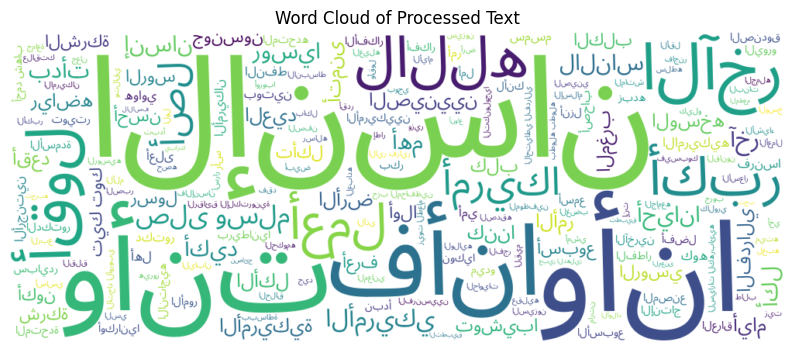

In [65]:

text_combined = " ".join(df['processed_text'])
font_path = "NotoSansArabic-VariableFont_wdth,wght.ttf"
wordcloud = WordCloud(
    font_path=font_path, 
    width=1000,
    height=400,
    background_color='white'
).generate(text_combined)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Processed Text")
plt.show()

In [66]:
df.columns

Index(['title', 'channel', 'category', 'transcript', 'raw_length',
       'clean_transcript', 'bert_tokens', 'farasa_tokens', 'total_tokens',
       'tokens_no_stop', 'total_tokens_no_stop', 'tokens_no_stop_additional',
       'total_tokens_no_stop_custom', 'stemmed_tokens', 'lemmatized_tokens',
       'stem_length', 'lemma_length', 'processed_text'],
      dtype='object')

### Classification model to compare accuracies

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate_model(text_column):
    # Get the text data
    X = df[text_column]
    
    # If the first entry is a list, join the tokens into a single string for each document
    if isinstance(X.iloc[0], list):
        X = X.apply(lambda tokens: " ".join(tokens))
        
    y = df['category']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert text to numerical features using TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    # Create and train the Logistic Regression model
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train_vec, y_train)
    
    # Predict on the test set and compute accuracy
    y_pred = clf.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    return acc

# Evaluate the model using different text representations
raw_acc = evaluate_model('processed_text')
stemmed_acc = evaluate_model('stemmed_tokens')
lemmatized_acc = evaluate_model('lemmatized_tokens')

print("Accuracy using processed text: {:.4f}".format(raw_acc))
print("Accuracy using stemmed text: {:.4f}".format(stemmed_acc))
print("Accuracy using lemmatized text: {:.4f}".format(lemmatized_acc))


Accuracy using processed text: 0.8667
Accuracy using stemmed text: 0.8667
Accuracy using lemmatized text: 0.8667
